**This notebook aims to analyze and prepare data for the Amex Default Prediction Project. The key steps include:**

**Loading the training and test datasets**

**Performing Exploratory Data Analysis (EDA)**

**Conducting Data Preprocessing**

**Applying Feature Selection using:**

**Information Value (IV) for predictive power**

**Correlation analysis to identify and remove multicollinearity**

**This notebook explains the process and technique how from 189 features we reduced the features to 72 odd features**

**For the sake of data security the column names have been renamed by Amex while sharing it on Kaggle**

## Importing all the required libraries ##

In [1]:
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the train dataset of Amex and merging it with the target(customer default) variable present within train_labels ##

#### Since the train data is of 18 Gb , we shall consider 70k records from the train set to build the model and to be able to push the data files into Github repository ####

In [2]:
train_iter_obj = pd.read_csv('/Users/anugrahrastogi21gmail.com/Downloads/amex-default-prediction/train_data.csv', chunksize=7_000_0)  # 0.5 million rows per chunk

for train_chunk in train_iter_obj:
    print(train_chunk.shape)
    # process or save each chunk
    train_chunk.to_csv("/Users/anugrahrastogi21gmail.com/Documents/USD_project/customer-credit-default-prediction/01_data/train_data.csv", index=False)
    break
    

(70000, 190)


In [3]:
train_df = pd.read_csv("/Users/anugrahrastogi21gmail.com/Documents/USD_project/customer-credit-default-prediction/01_data/train_data.csv")
memory_bytes = train_df.memory_usage(deep=True).sum()
memory_mb = memory_bytes / (1024 * 1024)
print(memory_mb)
train_labels_df = pd.read_csv("/Users/anugrahrastogi21gmail.com/Downloads/amex-default-prediction/train_labels.csv")

train_df_complete = pd.merge(train_df, train_labels_df, how="inner", on="customer_ID")

train_df_complete.shape, train_df.shape

117.51184463500977


((70000, 191), (70000, 190))

## EDA (Exploraotory data analysis) ##

#### Description of the train dataset ####

In [4]:
train_df_complete.describe().T  

,count,mean,std,min,25%,50%,75%,max
P_2,69427.0,0.655315,0.246852,-3.830190e-01,0.476650,0.694480,0.866688,1.009998
D_39,70000.0,0.154490,0.272714,8.701630e-07,0.004576,0.009121,0.236133,5.331360
B_1,70000.0,0.126764,0.215641,-1.956662e-01,0.008832,0.032111,0.129060,1.324053
B_2,69977.0,0.614745,0.402095,3.308280e-06,0.098566,0.814030,1.002162,1.010000
R_1,70000.0,0.080526,0.229780,2.880975e-07,0.002870,0.005756,0.008651,2.507711
...,...,...,...,...,...,...,...,...
D_142,11789.0,0.392237,0.243633,-1.394664e-02,0.188239,0.384605,0.569647,1.751388
D_143,68765.0,0.176145,0.376643,1.653580e-08,0.003019,0.006060,0.009040,1.010000
D_144,69490.0,0.054539,0.188182,4.053056e-07,0.002748,0.005501,0.008259,1.343284
D_145,68765.0,0.060399,0.196428,4.609489e-08,0.003030,0.006021,0.009040,4.282032


#### Observing the above description of the train dataset , convert 'S_2' column which is a date column to datetime ####

In [5]:
train_df_complete['S_2'] = pd.to_datetime(train_df_complete['S_2'])

#### Count of numerical and caterocial columns ####

In [6]:
numerical_columns = train_df_complete.select_dtypes(include=['number']).columns.tolist()
categorical_columns = train_df_complete.select_dtypes(include=['object', 'category']).columns.tolist()

print("number of numerical columns: ", len(numerical_columns),'\n', 
      "number of categorical columns: ", len(categorical_columns))


number of numerical columns:  187 
 number of categorical columns:  3


#### As observed above, there are 187 numerical columns and 3 categorical columns ####

#### checking whether there are null values in the train dataset ####

In [7]:
null_value_df = pd.DataFrame({'column_name':train_df_complete.isnull().sum().index, 
                                 'null_count':train_df_complete.isnull().sum().values})

null_value_df["percent_missing"] = null_value_df["null_count"]*100 / len(train_df_complete)
null_value_df.sort_values('percent_missing',  ascending=False).to_csv("null_percentage_df.csv", index=False)



#### Removing columns which have more than 90% of null values ####

In [8]:
null_columns = null_value_df[null_value_df["percent_missing"] > 90]["column_name"].to_list()
print("count of null value columns to be dropeed: ", len(null_columns))
train_df_complete = train_df_complete.drop(null_columns, axis=1)
print("shape of train dataset after droppping null valued columns: ", train_df_complete.shape)

count of null value columns to be dropeed:  15
shape of train dataset after droppping null valued columns:  (70000, 176)


#### checking whether there are zero values in the train dataset ####

In [9]:
zero_value_df = pd.DataFrame({
    'column_name': train_df_complete.columns,
    'zero_count': (train_df_complete == 0).sum().values
})

# Add percentage of zero values
zero_value_df['percent_zeros'] = (zero_value_df['zero_count'] * 100) / len(train_df_complete)

# Sort by highest percentage of zeros
zero_value_df = zero_value_df.sort_values('percent_zeros', ascending=False)
zero_value_df.to_csv("zero_percentage_df.csv", index=False)
zero_value_df

,column_name,zero_count,percent_zeros
148,D_116,67703,96.718571
152,D_120,59542,85.060000
102,B_30,59400,84.857143
175,target,52354,74.791429
146,D_114,25380,36.257143
...,...,...,...
169,D_140,0,0.000000
171,D_142,0,0.000000
172,D_143,0,0.000000
173,D_144,0,0.000000


#### Removing columns which have more than 90% zero values since no variance would be present in those columns ####

In [10]:
zero_columns = zero_value_df[zero_value_df["percent_zeros"] > 90]["column_name"].to_list()
print("count of zero value columns to be dropped: ", len(zero_columns))
train_df_complete = train_df_complete.drop(zero_columns, axis=1)
print("shape of train dataset after droping zero valued columns: ", train_df_complete.shape)

count of zero value columns to be dropped:  1
shape of train dataset after droping zero valued columns:  (70000, 175)


#### Total of 19 columns dropped from the dataset due to null and zero value percentage ####

#### Distribution of target variable ####

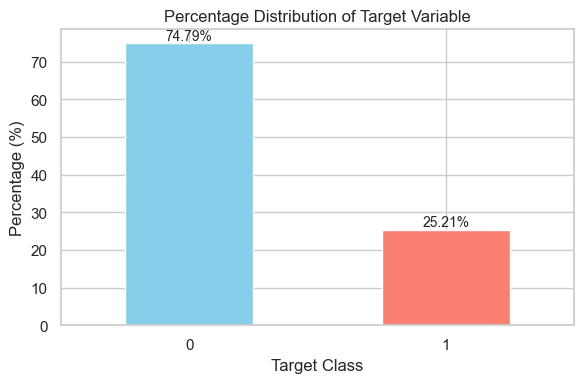

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Calculate percentages
target_counts = train_df_complete['target'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add labels and title
plt.xlabel('Target Class')
plt.ylabel('Percentage (%)')
plt.title('Percentage Distribution of Target Variable')
plt.xticks(rotation=0)

# Add percentage labels on bars
for i, value in enumerate(target_counts):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


#### From the above distribution we observe its a class imbalance problem statement, since target = 1 records are way lesser compared to target = 0 cases ####

### Data pre-processing ####

#### For all the numerical variables we construct a box plot to observe the skewness and outliers ####

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Filter numerical columns
numerical_cols = train_df_complete.select_dtypes(include='number').columns

# Create PDF to save plots
with PdfPages('box_plots_numerical_features.pdf') as pdf:
    for col in numerical_cols:
        if col != 'target':
            
            plt.figure(figsize=(8, 4))
            plt.boxplot(train_df_complete[col].dropna(), vert=False)
            plt.title(f'Box Plot of {col}')
            plt.xlabel(col)
            plt.tight_layout()
            # Save each plot to the PDF
            pdf.savefig()
            plt.close()

print("Box plots saved to 'box_plots_numerical_features.pdf'")


Box plots saved to 'box_plots_numerical_features.pdf'


#### Since there are more then 180 numerical columns we have saved the box plot distribution named: box_plots_numerical_features.pdf ####

**As we observe one of the variables named "P_2" from the above pdf file generated, the plot has outliers hence we need to remove the outliers we use capping in this scenario**

#### First calculate IQR (inter-quartile range) ####

In [13]:
percentile25 = train_df_complete['P_2'].quantile(0.25)
percentile75 = train_df_complete['P_2'].quantile(0.75)
iqr = percentile75-percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr


#### Perform capping ####

In [14]:
train_df_complete['P_2'] = np.where(train_df_complete['P_2'] >= upper_limit,
        upper_limit,
        np.where(train_df_complete['P_2'] <= lower_limit,
        lower_limit,
        train_df_complete['P_2']))

#### After removing outlier ####

<Axes: ylabel='P_2'>

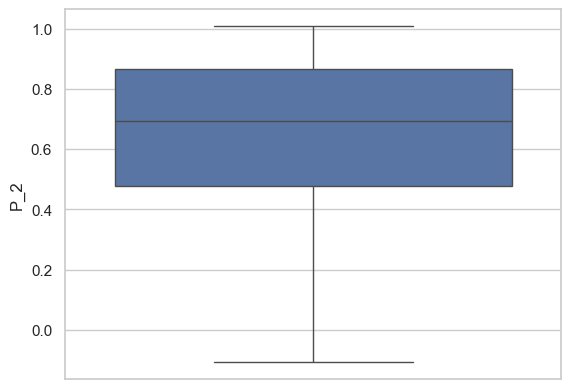

In [15]:
sns.boxplot(train_df_complete['P_2'])

#### Removing the outliers , only result in some information loss, since we cap the end values of a column ####

#### Categorical variables distribution vs target ####

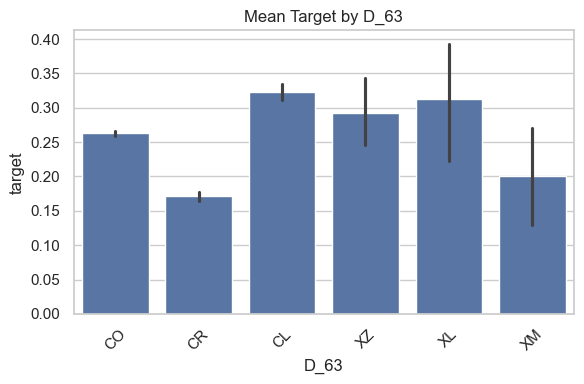

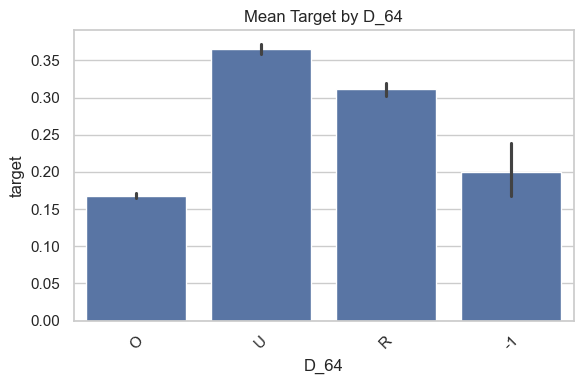

In [16]:
for col in categorical_columns:
    if col != "customer_ID":
        
        plt.figure(figsize=(6, 4))
        sns.barplot(data=train_df_complete, x=col, y='target', estimator='mean', order=train_df_complete[col].value_counts().index)
        plt.title(f'Mean Target by {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


## Feature selection technique (Information Value) ##

#### Information Value (IV) is a common metric in credit risk modeling to measure the predictive power of a variable in distinguishing between good and bad outcomes (e.g., defaulters vs non-defaulters) ####


**IV Interpretation Guide**

**IV Value	Predictive Strength**

**< 0.02	Not useful**

**0.02–0.1	Weak**

**0.1–0.3	Medium**

**0.3–0.5	Strong**

**> 0.5	Suspicious (check for leakage)**

In [17]:
def calculate_iv(df, feature, target, bins=10):
    """
    Calculate Information Value (IV) for a single feature.
    
    Parameters:
    - df: pandas DataFrame
    - feature: the column name of the feature
    - target: the binary target variable (0 = good, 1 = bad)
    - bins: number of bins for numerical variables
    
    Returns:
    - iv (float): Information Value of the feature
    """
    temp_df = df[[feature, target]].copy()

    # Bin if numerical
    if pd.api.types.is_numeric_dtype(temp_df[feature]):
        try:
            temp_df['bin'] = pd.qcut(temp_df[feature], q=bins, duplicates='drop')
        except ValueError:  # Handle features with fewer unique values than bins
            temp_df['bin'] = temp_df[feature]
    else:
        temp_df['bin'] = temp_df[feature]

    # Grouping and WOE/IV calculation
    grouped = temp_df.groupby('bin')[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bads']
    grouped['goods'] = grouped['total'] - grouped['bads']

    # Percentages
    grouped['% of Bads'] = grouped['bads'] / grouped['bads'].sum()
    grouped['% of Goods'] = grouped['goods'] / grouped['goods'].sum()

    # Add small value to avoid division by zero
    grouped['WOE'] = np.log((grouped['% of Goods'] + 1e-6) / (grouped['% of Bads'] + 1e-6))
    grouped['IV'] = (grouped['% of Goods'] - grouped['% of Bads']) * grouped['WOE']

    iv = grouped['IV'].sum()

    return iv


In [18]:
def calculate_iv_all_features(df, target_col):
    """
    Calculate IV for all features in a DataFrame (excluding the target).
    
    Parameters:
    - df: pandas DataFrame
    - target_col: the name of the target column (binary: 0 = good, 1 = bad)
    - bins: number of bins for numeric features
    
    Returns:
    - DataFrame: sorted IV values for each feature
    """
    iv_dict = {}
    feature_cols = df.columns.drop([target_col, 'customer_ID'])

    for col in feature_cols:
        try:
            iv = calculate_iv(df, col, target_col)
            iv_dict[col] = iv
        except Exception as e:
            print(f"Skipped {col} due to error: {e}")
            continue

    iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV'])
    iv_df = iv_df.sort_values(by='IV', ascending=False)
    return iv_df


In [19]:
# Example: Assuming your target column is named 'target'
iv_result = calculate_iv_all_features(train_df_complete, target_col='target').reset_index()
iv_result.to_csv("IV_result.csv", index=False)

/var/folders/2n/0w23czwn2mjd3pg0c15vjyz80000gn/T/ipykernel_33054/2044337124.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby('bin')[target].agg(['count', 'sum'])
/var/folders/2n/0w23czwn2mjd3pg0c15vjyz80000gn/T/ipykernel_33054/2044337124.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby('bin')[target].agg(['count', 'sum'])
/var/folders/2n/0w23czwn2mjd3pg0c15vjyz80000gn/T/ipykernel_33054/2044337124.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

#### Removing features who have weak predictive power i.e IV < 0.02 ####

In [20]:
columns_to_remove_weak_iv = iv_result[iv_result["IV"] < 0.02]["index"].to_list()
len(columns_to_remove_weak_iv)

38

#### Removing features who have suprisingly higher predictive power i.e IV > 0.5 ####

In [21]:
columns_to_remove_hyper_iv = iv_result[iv_result["IV"] > 0.5]["index"].to_list()
len(columns_to_remove_hyper_iv)

47

#### Concatinating both the lists and removing these features from the train dataset ####

In [22]:
columns_to_remove_weak_iv.extend(columns_to_remove_hyper_iv)
len(columns_to_remove_weak_iv)

85

#### Dropped 85 features from IV method ####

In [23]:
train_df_complete.drop(columns_to_remove_weak_iv, axis=1, inplace=True)
train_df_complete.shape

(70000, 90)

#### Apply pearson correlation to remove highly correlated variables on the above train dataset ####

In [24]:
def correlation(dataset, threshold, verbose=False):
    """
    Identify highly correlated features to drop based on a threshold.

    Parameters:
    - dataset (pd.DataFrame): The input DataFrame with numeric columns.
    - threshold (float): Correlation threshold above which to drop one of the variables.
    - verbose (bool): If True, prints each pair of correlated features.

    Returns:
    - col_corr (set): Set of column names to consider for dropping.
    """
    col_corr = set()
    corr_matrix = dataset.corr(numeric_only=True)

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            corr_value = abs(corr_matrix.iloc[i, j])
            if corr_value > threshold:
                colname = corr_matrix.columns[i]
                if verbose:
                    print(f"High correlation ({corr_value:.2f}) between: {colname} and {corr_matrix.columns[j]}")
                col_corr.add(colname)
    return col_corr


#### Removing correlated features with threshold greater than or equal to 75% ####

In [25]:
high_corr_cols = correlation(train_df_complete, threshold=0.75, verbose=True)
train_df_complete_corr = train_df_complete.drop(columns=high_corr_cols)
print("Final train dataset shape: ", train_df_complete_corr.shape)

High correlation (0.78) between: R_4 and R_2
High correlation (0.92) between: B_13 and B_12
High correlation (0.80) between: S_15 and S_8
High correlation (0.79) between: R_8 and R_5
High correlation (0.78) between: S_16 and B_21
High correlation (0.77) between: D_84 and D_53
High correlation (1.00) between: D_104 and D_103
High correlation (0.85) between: D_107 and D_103
High correlation (0.84) between: D_107 and D_104
High correlation (0.82) between: D_118 and D_115
High correlation (0.82) between: D_119 and D_115
High correlation (1.00) between: D_119 and D_118
High correlation (0.75) between: D_129 and D_128
High correlation (0.90) between: D_131 and D_79
High correlation (0.92) between: D_132 and D_131
High correlation (1.00) between: D_141 and D_139
High correlation (0.80) between: D_142 and D_141
High correlation (1.00) between: D_143 and D_139
High correlation (1.00) between: D_143 and D_141
Final train dataset shape:  (70000, 74)


#### Dropped 16 features using pearson correlation ####

#### Perform one-hot encoding for 2 categorical features ####

In [26]:
cat_cols = ["D_64", "D_63"]
train_df_complete_corr_encd = pd.get_dummies(train_df_complete_corr, columns=cat_cols)

#### Saving the processed and final train and test datasets ####

In [27]:
train_df_complete_corr_encd.to_csv("/Users/anugrahrastogi21gmail.com/Documents/USD_project/customer-credit-default-prediction/01_data/processed_train_data.csv", 
                              index=False)


#### Since the test data is of 33Gb, we need to reduce the size of our test data to 33k records and to be able to push the data files into Github repository #### 

In [28]:

test_iter = pd.read_csv('/Users/anugrahrastogi21gmail.com/Downloads/amex-default-prediction/test_data.csv', chunksize=33_000)  # 1 million rows per chunk

for chunk in test_iter:
    print(chunk.shape)
    # process or save each chunk
    chunk.to_csv("/Users/anugrahrastogi21gmail.com/Documents/USD_project/customer-credit-default-prediction/01_data/test_data.csv", index=False)
    break
    

(33000, 190)


In [39]:
test_df = pd.read_csv("/Users/anugrahrastogi21gmail.com/Documents/USD_project/customer-credit-default-prediction/02_data_prep/test_data.csv")
columns_list = train_df_complete_corr.columns.to_list()
columns_list.remove("target")
test_df = test_df[columns_list]
cat_cols = ["D_64", "D_63"]
test_df_encd = pd.get_dummies(test_df, columns=cat_cols)
test_df_encd.to_csv("/Users/anugrahrastogi21gmail.com/Documents/USD_project/customer-credit-default-prediction/01_data/processed_test_data.csv", index=False)

